In [1]:
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os

# Initialize weights and bias 
def weight_variable(name, shape_in):
    return tf.get_variable(name,shape=shape_in, initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(name, shape_in):
    return tf.get_variable(name,shape=shape_in, initializer=tf.contrib.layers.xavier_initializer())

In [2]:
data1 = scipy.io.loadmat('data/dataset.mat')
data2 = scipy.io.loadmat('data/dataset2.mat')

data_x = np.concatenate([data1['X'], data2['X']], axis = 0)
data_y = np.concatenate([data1['Y'], data2['Y']], axis = 0)

normalization_factor = [1.0/5, 1.0/5, 1.0/20, 1.0/20, 1.0, 1.0]
normalization_bias = [0.0, 0, 0, 0, 0, 0]

data_x[:,4,:] = 1/data_x[:,4,:]
data_y[:,4,:] = 1/data_y[:,4,:]
data_x[:,5,:] = 1/data_x[:,5,:]
data_y[:,5,:] = 1/data_y[:,5,:]
data_x[:,4,5] = 0
data_y[:,4,5] = 0
data_x[:,5,5] = 0
data_y[:,5,5] = 0

for i in range(len(normalization_factor)):
    data_x[:,i,:] = data_x[:,i,:] * normalization_factor[i] + normalization_bias[i]
    data_y[:,i,:] = data_y[:,i,:] * normalization_factor[i] + normalization_bias[i]

print(np.shape(data_x), np.shape(data_y))

print(data_x[0,5,:])
print(data_y[0,5,:])


(500000, 6, 6) (500000, 6, 6)
[0.66666667 1.         1.         1.24999998 0.8333333  0.        ]
[0.66666667 1.         1.         1.24999998 0.8333333  0.        ]


In [3]:
def interaction_net(O,Rr,Rs,Ra,X, output_len):

    object_state = O.get_shape()[-2]
    object_num = O.get_shape()[-1]
    
    relation_num = Rr.get_shape()[-1]
    
    B = tf.concat([tf.matmul(O,Rr),tf.matmul(O,Rs),Ra], axis = 1)
    
    B_len = B.get_shape()[-2]

    print(O.get_shape())
    print(Rr.get_shape())
    print(B.get_shape())
    
    fR_hidden_num = 100
    fR_hidden_layer = 3
    
    fR_weight = [weight_variable('fR_w_h'+str(i), [fR_hidden_num, fR_hidden_num]) for i in range(fR_hidden_layer-1)]
    fR_weight.insert(0, weight_variable('fR_w_input', [B_len, fR_hidden_num]))
    fR_bias = [bias_variable('fR_b_h'+str(i), [fR_hidden_num]) for i in range(fR_hidden_layer-1)]
    fR_bias.insert(0, bias_variable('fR_b_input',[fR_hidden_num]))
    
    e_list = []
    
    for i in range(relation_num):
        temp_B = tf.reshape(tf.slice(B,[0,0,i],[-1,-1,1]),[-1, B_len])
        for layer in range(fR_hidden_layer):
            if layer == 0:
                fR_hidden_state = tf.nn.relu(tf.matmul(temp_B, fR_weight[layer]) + fR_bias[layer])
            else:
                fR_hidden_state = tf.nn.relu(tf.matmul(fR_hidden_state, fR_weight[layer]) + fR_bias[layer])
        
        e_list.append(fR_hidden_state)
        
    E = tf.stack(e_list, axis = 2)
    E_bar = tf.matmul(E, Rr, transpose_b = True)
    
    print(E.get_shape())
    print(E_bar.get_shape())
    
    C = tf.concat([O, X, E_bar], axis = 1)
    
    C_len = C.get_shape()[-2]
    
    print(C.get_shape())
    
    fO_hidden_num = 150
    fO_hidden_layer = 3
    
    fO_weight = [weight_variable('fO_w_h'+str(i), [fO_hidden_num, fO_hidden_num]) for i in range(fO_hidden_layer-1)]
    fO_weight.insert(0, weight_variable('fO_w_input', [C_len, fO_hidden_num]))
    fO_bias = [bias_variable('fO_b_h'+str(i), [fO_hidden_num]) for i in range(fO_hidden_layer-1)]
    fO_bias.insert(0, bias_variable('fO_b_input',[fO_hidden_num]))
    
    output_weight = weight_variable('out_w', [fO_hidden_num, output_len])
    output_bias = weight_variable('out_b', [output_len])
    
    out_list = []
    
    for i in range(object_num):
        temp_C = tf.reshape(tf.slice(C,[0,0,i],[-1,-1,1]),[-1, C_len])
        for layer in range(fO_hidden_layer):
            if layer == 0:
                fO_hidden_state = tf.nn.relu(tf.matmul(temp_C, fO_weight[layer]) + fO_bias[layer])
            else:
                fO_hidden_state = tf.nn.relu(tf.matmul(fO_hidden_state, fO_weight[layer]) + fO_bias[layer])
                
        temp_out = tf.matmul(fO_hidden_state, output_weight) + output_bias
        out_list.append(temp_out)
    
    output = tf.stack(out_list, axis = 2)
    
    print(output)        
    
    return output
 

In [4]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

object_state = np.shape(data_x)[-2]
object_num = np.shape(data_x)[-1]
# object_num = 1

relation_num = 30
relation_state = 1

external_state = 1

object_input = tf.placeholder(tf.float32, [None, object_state, object_num])
relation_r = tf.placeholder(tf.float32, [None, object_num, relation_num])
relation_s = tf.placeholder(tf.float32, [None, object_num, relation_num])
relation_a = tf.placeholder(tf.float32, [None, relation_state, relation_num])
external = tf.placeholder(tf.float32, [None, external_state, object_num])

loss_state_num = 4

y = tf.placeholder(tf.float32, [None, loss_state_num, object_num])

predictions = interaction_net(object_input,relation_r,relation_s,relation_a,external, output_len = loss_state_num)

loss = tf.reduce_mean(tf.reduce_mean(tf.reduce_mean(tf.square(y - predictions), axis = 1), axis = 1)) + 1

print(loss.get_shape())

lr = tf.placeholder(tf.float32)

train_step = tf.train.AdamOptimizer(lr).minimize(loss)

sess.run(tf.global_variables_initializer())

(?, 6, 6)
(?, 6, 30)
(?, 13, 30)
Instructions for updating:
Use the retry module or similar alternatives.
(?, 100, 30)
(?, 100, 6)
(?, 107, 6)
Tensor("stack_1:0", shape=(?, 4, 6), dtype=float32)
()


In [5]:


batch_size = 256
epoch_num = 10

train_data_num = np.shape(data_x)[0]

for epoch in range(epoch_num):
    order = np.arange(train_data_num)
    np.random.shuffle(order)
    temp_train_x = data_x[order]
    temp_train_y = data_y[order]
    for batch_step in range(int(train_data_num/batch_size)+1):
        batch_idx = [batch_step*batch_size, (batch_step+1)*batch_size]
        if batch_idx[1] > train_data_num: batch_idx[1] = train_data_num
        
        batch_x = temp_train_x[batch_idx[0]:batch_idx[1]]
        batch_y = temp_train_y[batch_idx[0]:batch_idx[1]]
        batch_y = batch_y[:,0:loss_state_num,:]
        
        batch_Rr = np.zeros([batch_idx[1]-batch_idx[0], object_num, relation_num])
        batch_Rs = np.zeros([batch_idx[1]-batch_idx[0], object_num, relation_num])
        batch_Ra = np.zeros([batch_idx[1]-batch_idx[0], relation_state, relation_num])
        
        batch_external = np.zeros([batch_idx[1]-batch_idx[0], external_state, object_num])
        
        relation_idx = 0
        for i in range(object_num):
            for j in range(object_num):
                if i is not j:
                    batch_Rs[:,i,relation_idx] = 1
                    batch_Rr[:,j,relation_idx] = 1
                    relation_idx = relation_idx + 1
                    
        train_step.run(feed_dict={object_input: batch_x, y: batch_y, relation_r: batch_Rr, relation_s: batch_Rs, relation_a: batch_Ra, external: batch_external, lr: 0.0001})
        loss_value = loss.eval(feed_dict={object_input: batch_x, y: batch_y, relation_r: batch_Rr, relation_s: batch_Rs, relation_a: batch_Ra, external: batch_external})
        print_num = int((batch_step/(int(train_data_num/batch_size)+1))*30)
        print_string = "epoch %d/%d, ["%(epoch+1,epoch_num)+"="*print_num+" "*(30-print_num) +"] loss = "+"%g"%(loss_value)
        print(print_string, end="\r")
        
    
    sample = 2048
    temp_loss=np.zeros([int(train_data_num/sample)+1])
    for batch_step in range(int(train_data_num/sample)+1):
        batch_idx = [batch_step*sample, (batch_step+1)*sample]
        if batch_idx[1] > train_data_num: batch_idx[1] = train_data_num
            
        batch_x = temp_train_x[batch_idx[0]:batch_idx[1]]
        batch_y = temp_train_y[batch_idx[0]:batch_idx[1]]
        batch_y = batch_y[:,0:loss_state_num,:]
        
        batch_Rr = np.zeros([batch_idx[1]-batch_idx[0], object_num, relation_num])
        batch_Rs = np.zeros([batch_idx[1]-batch_idx[0], object_num, relation_num])
        batch_Ra = np.zeros([batch_idx[1]-batch_idx[0], relation_state, relation_num])
        
        batch_external = np.zeros([batch_idx[1]-batch_idx[0], external_state, object_num])
        
        relation_idx = 0
        for i in range(object_num):
            for j in range(object_num):
                if i is not j:
                    batch_Rs[:,i,relation_idx] = 1
                    batch_Rr[:,j,relation_idx] = 1
                    relation_idx = relation_idx + 1
        loss_value = loss.eval(feed_dict={object_input: batch_x, y: batch_y, relation_r: batch_Rr, relation_s: batch_Rs, relation_a: batch_Ra, external: batch_external})
        temp_loss[batch_step] = loss_value * (batch_idx[1]-batch_idx[0])
        # print("temp accuracy %g"%temp_temp)
    temp_loss = np.sum(temp_loss)/train_data_num
    
    print("\nepoch %d/%d, loss= %g"%(epoch+1, epoch_num, temp_loss))
    

epoch 1/10, [============================= ] loss = 1.00088
epoch 1/10, loss= 1.0019
epoch 2/10, [============================= ] loss = 1.00062
epoch 2/10, loss= 1.0016
epoch 3/10, [============================= ] loss = 1.00048
epoch 3/10, loss= 1.0013
epoch 4/10, [============================= ] loss = 1.00039
epoch 4/10, loss= 1.00113
epoch 5/10, [============================= ] loss = 1.00014
epoch 5/10, loss= 1.00109
epoch 6/10, [============================= ] loss = 1.00334
epoch 6/10, loss= 1.00107
epoch 7/10, [============================= ] loss = 1.00008
epoch 7/10, loss= 1.00103
epoch 8/10, [============================= ] loss = 1.00013
epoch 8/10, loss= 1.00105
epoch 9/10, [============================= ] loss = 1.00418
epoch 9/10, loss= 1.00098
epoch 10/10, [============================= ] loss = 1.00073
epoch 10/10, loss= 1.00093


In [6]:
print(tf.trainable_variables(scope=None))

[<tf.Variable 'fR_w_h0:0' shape=(100, 100) dtype=float32_ref>, <tf.Variable 'fR_w_h1:0' shape=(100, 100) dtype=float32_ref>, <tf.Variable 'fR_w_input:0' shape=(13, 100) dtype=float32_ref>, <tf.Variable 'fR_b_h0:0' shape=(100,) dtype=float32_ref>, <tf.Variable 'fR_b_h1:0' shape=(100,) dtype=float32_ref>, <tf.Variable 'fR_b_input:0' shape=(100,) dtype=float32_ref>, <tf.Variable 'fO_w_h0:0' shape=(150, 150) dtype=float32_ref>, <tf.Variable 'fO_w_h1:0' shape=(150, 150) dtype=float32_ref>, <tf.Variable 'fO_w_input:0' shape=(107, 150) dtype=float32_ref>, <tf.Variable 'fO_b_h0:0' shape=(150,) dtype=float32_ref>, <tf.Variable 'fO_b_h1:0' shape=(150,) dtype=float32_ref>, <tf.Variable 'fO_b_input:0' shape=(150,) dtype=float32_ref>, <tf.Variable 'out_w:0' shape=(150, 4) dtype=float32_ref>, <tf.Variable 'out_b:0' shape=(4,) dtype=float32_ref>]


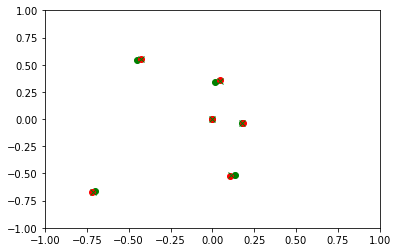

In [7]:
plt.figure(1)
test_idx = 50

batch_x = data_x[test_idx:(test_idx+1)]
batch_y = data_y[test_idx:(test_idx+1)]
batch_y = batch_y[:,0:loss_state_num,:]

batch_Rr = np.zeros([1, object_num, relation_num])
batch_Rs = np.zeros([1, object_num, relation_num])
batch_Ra = np.zeros([1, relation_state, relation_num])

batch_external = np.zeros([1, external_state, object_num])

relation_idx = 0
for i in range(object_num):
    for j in range(object_num):
        if i is not j:
            batch_Rs[:,i,relation_idx] = 1
            batch_Rr[:,j,relation_idx] = 1
            relation_idx = relation_idx + 1

pred = predictions.eval(feed_dict={object_input: batch_x, y: batch_y, relation_r: batch_Rr, relation_s: batch_Rs, relation_a: batch_Ra, external: batch_external})
# print(pred)
plt.plot(data_x[test_idx,0,:], data_x[test_idx,1,:], 'go')
plt.plot(data_y[test_idx,0,:], data_y[test_idx,1,:], 'ro')
plt.plot(pred[0,0,:], pred[0,1,:], 'gx')
plt.axis([-1, 1, -1, 1])
plt.show()